In [24]:
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import pickle
from tqdm.notebook import tqdm 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from utils.preprocess import NDF
from transformers.drop_nontrain import drop_nontrain_table as drop_nontrain



In [25]:
subsample = 0.05

In [26]:
import pyarrow as pa
import pyarrow.parquet as pq
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.api.types")
warnings.filterwarnings("ignore", message="is_sparse is deprecated", category=FutureWarning)
warnings.filterwarnings("ignore", message="is_categorical_dtype is deprecated", category=FutureWarning)

benign = pq.read_table('floor/inputs-for-petr/benign_2312.parquet')
phishing = pq.read_table('floor/inputs-for-petr/phishing_2311.parquet')

phishing_domain_names = phishing['domain_name']
benign_domain_names = benign['domain_name']

phishing_len = len(phishing_domain_names)
benign_len = len(benign_domain_names)

from transformers.drop_nontrain import drop_nontrain_table as drop_nontrain
phishing = drop_nontrain(phishing)
benign = drop_nontrain(benign)

# realign schemas (parquet files save in nonsense orders)
benign = benign.cast(phishing.schema)

# concatentate tables
data = pa.concat_tables([phishing, benign])
df = data.to_pandas()
df = df.drop(columns=['domain_name'])

from transformers.cast_timestamp import cast_timestamp
df = cast_timestamp(df)
df = df.sample(frac=subsample, random_state=42)

# create train and test sets
from config import Config
from sklearn.model_selection import train_test_split

class_map = {}
#get class map dynamically
for i, label in enumerate(df['label'].unique()):
    class_map[label] = i

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

X_train, X_test, y_train, y_test = train_test_split(
  features,
  labels,
  test_size=0.3,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

df.head()

,label,dns_has_dnskey,dns_A_count,dns_AAAA_count,dns_MX_count,dns_NS_count,dns_TXT_count,dns_SOA_count,dns_CNAME_count,dns_zone_level,...,rdap_ip_v4_count,rdap_ip_v6_count,rdap_ip_shortest_v4_prefix_len,rdap_ip_longest_v4_prefix_len,rdap_ip_shortest_v6_prefix_len,rdap_ip_longest_v6_prefix_len,rdap_ip_avg_admin_name_len,rdap_ip_avg_admin_name_entropy,rdap_ip_avg_admin_email_len,rdap_ip_avg_admin_email_entropy
110524,benign_2310:unknown,0.0,2,0,2,4,6,1,0,0,...,10,8,17.0,23.0,28.0,47.0,7.222222,0.138415,12.777778,0.083267
247921,benign_2310:unknown,0.0,0,0,0,0,0,0,1,0,...,1,0,19.0,19.0,0.0,0.0,21.000000,0.178524,34.000000,0.106803
204836,benign_2310:unknown,0.0,1,1,0,0,0,0,0,1,...,1,1,22.0,22.0,29.0,29.0,13.500000,0.261074,22.000000,0.180135
183722,benign_2310:unknown,1.0,3,3,0,0,0,0,0,0,...,3,3,12.0,13.0,32.0,32.0,5.000000,0.464386,18.000000,0.198468
62984,misp_2310:phishing,0.0,2,2,0,0,0,0,0,0,...,2,2,22.0,22.0,32.0,32.0,24.000000,0.163262,20.000000,0.186096


# XGBoost

### Hyperopt with bayesian optimization

Automated hyperparameter optimization using Hyperopt, a Python library for serial and parallel optimization over awkward search spaces. Hyperopt facilitates the search for the best hyperparameters of the model by employing algorithms like Tree-structured Parzen Estimators (TPE).

Additionally, I'll demonstrate how to use early stopping to prevent overfitting and ensure that your model is as generalized as possible. Early stopping monitors a model's performance on a validation set and halts training when performance ceases to improve, thus saving computational resources and preventing overfitting

`Pros:` Easy to use, fast, and efficient, with early stopping \
`Cons:` None

In [27]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from sklearn.metrics import f1_score

# Define the space of hyperparameters to search
space = {
    'max_depth': scope.int(hp.quniform('max_depth', 6, 12, 3)),     
    'learning_rate': hp.choice('learning_rate', [0.05, 0.1, 0.15, 0.2, 0.25]),  
    'min_child_weight': hp.choice('min_child_weight', [1.0, 2.0, 3.0, 4.0, 5.0]),
    'subsample': hp.choice('subsample', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
    'alpha': hp.choice('alpha', [0, 0.05, 0.1, 0.2, 0.5]),
    'gamma': hp.choice('gamma', [0.05, 0.1, 0.2, 0.3, 0.4]),
    'lambda': hp.uniform('lambda', 1.0, 2.0),
    'n_estimators': hp.choice('n_estimators', [100, 200, 300]),  
    'colsample_bytree': hp.choice('colsample_bytree', [0.7, 0.8, 0.9, 1.0])
}


# Objective function to minimize
def objective(params):
    model = xgb.XGBClassifier(
        **params,
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss'
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=100,
        verbose=False
    )
    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds, average='binary')
    return {'loss': -f1, 'status': STATUS_OK}

# Run the hyperparameter search using the tpe algorithm
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=1000,
    trials=trials,
)

print("Best: ", best)


100%|██████████| 1000/1000 [37:12<00:00,  2.23s/trial, best loss: -0.9465875370919882]
Best:  {'alpha': 1, 'colsample_bytree': 1, 'gamma': 1, 'lambda': 1.5647683752757835, 'learning_rate': 1, 'max_depth': 6.0, 'min_child_weight': 3, 'n_estimators': 2, 'subsample': 4}


### Random Search
Random search is an alternative to grid search that samples parameter settings randomly for a fixed number of iterations.

`Pros:` This approach is more efficient than grid search because you can cover a wide range of values without a large number of iterations. \
`Cons:` It is not guaranteed to find the best hyperparameters, and it is not reproducible.

In [28]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

param_distributions = {
    "max_depth": [6, 9, 12],        # maximum distance between the root node and the leaf node
    "eta": [0.1, 0.15, 0.2],        # learning rate
    "min_child_weight": [1.0, 2.0], # 
    "subsample": [0.6, 0.8, 1.0],   # subsample ratio of the training instances
    "alpha": [0, 0.1, 0.5],         # L1 regularization
    "gamma": [0.1, 0.2, 0.3],       # minimum loss reduction which is required to make a further partition on a leaf node of the tree
    "lambda": [1.0, 1.5],           # L2 regularization
    "n_estimators": [100, 200, 300],     # number of trees
    "colsample_bytree": [0.8, 1.0], # subsample ratio of columns when constructing each tree
    "max_bin": [256, 512]           # maximum number of bins that feature values will be bucketed in
    
    # Uncomment the following lines if you want to use GPU
    # "tree_method": ["gpu_hist"],
    # "sampling_method": ["uniform", "gradient_based"],
}

# Create a base model without specifying 'n_estimators' here
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric=["error", "logloss", "auc"],
    grow_policy="lossguide",
    max_delta_step=0,
)

# Cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Search across 300 different combinations, and use all available cores
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_distributions, 
                                    n_iter=300, n_jobs=-1, cv=kfold, scoring='f1', verbose=3, random_state=42)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1 score: {random_search.best_score_:.2f}%")

# Train the model with the best parameters on the full training set, including 'n_estimators'
best_params = random_search.best_params_
best_model = XGBClassifier(**best_params, eval_metric=["error", "logloss", "auc"])
eval_set = [(X_train, y_train), (X_test, y_test)]
_ = best_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)






Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[CV 5/5] END alpha=0, colsample_bytree=0.8, eta=0.2, gamma=0.3, lambda=1.5, max_bin=256, max_depth=6, min_child_weight=2.0, n_estimators=100, subsample=0.6;, score=0.928 total time=  13.4s
[CV 4/5] END alpha=0, colsample_bytree=0.8, eta=0.2, gamma=0.3, lambda=1.5, max_bin=256, max_depth=6, min_child_weight=2.0, n_estimators=100, subsample=0.6;, score=0.924 total time=  13.4s
[CV 2/5] END alpha=0, colsample_bytree=0.8, eta=0.2, gamma=0.3, lambda=1.5, max_bin=256, max_depth=6, min_child_weight=2.0, n_estimators=100, subsample=0.6;, score=0.945 total time=  13.5s
[CV 1/5] END alpha=0, colsample_bytree=0.8, eta=0.2, gamma=0.3, lambda=1.5, max_bin=256, max_depth=6, min_child_weight=2.0, n_estimators=100, subsample=0.6;, score=0.931 total time=  14.5s
[CV 3/5] END alpha=0, colsample_bytree=0.8, eta=0.2, gamma=0.3, lambda=1.5, max_bin=256, max_depth=6, min_child_weight=2.0, n_estimators=100, subsample=0.6;, score=0.935 total time=  14.6s
[CV 5/5] END alpha=0.1, colsample_bytree=0.8, eta=0.15,

### Grid Search

Grid search is the process of performing hyperparameter tuning in order to determine the optimal values for a given model. This is significant as the performance of the entire model is based on the hyperparameter values specified.

`Pros:` It is exhaustive and straight-forward. \
`Cons:` It can be computationally expensive. 

In [29]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Parameters to try in the grid search
param_grid = {
    "max_depth": [6, 9, 12],  # Maximum depth of the tree
    "eta": [0.1, 0.2],  # Learning rate, 'eta' in XGBoost, corresponds to 'learning_rate'
    "min_child_weight": [1.0, 2.0],  # Minimum sum of instance weight needed in a child
    "subsample": [0.6, 0.8, 1.0],  # Fraction of observations to be randomly samples for each tree
    "alpha": [0, 0.1, 0.5],  # L1 regularization term on weights
    "gamma": [0.1, 0.3],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
    "lambda": [1.0, 1.5],  # L2 regularization term on weights
    "n_estimators": [200, 300],  # Number of trees in the ensemble
    "colsample_bytree": [0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    "max_bin": [256],  
    
    # Optional GPU usage lines are commented out as before
    # "tree_method": ["gpu_hist"],
    # "sampling_method": ["uniform", "gradient_based"],
}

# Use Early Stopping: Train the 
# model with a very high number of trees, but set up early stopping using a validation set. 
# The training will stop when the performance on the validation set stops improving, automatically determining the optimal number of trees.

# Create a base model
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric=["error", "logloss", "auc"],
    grow_policy="lossguide",
    max_delta_step=0,
)

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=-1, cv=kfold, scoring='f1', verbose=3)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_:.2f}%")

# Optionally: train the model with the best parameters on the full training set
# best_params = grid_search.best_params_
# best_model = XGBClassifier(**best_params, eval_metric=["error", "logloss", "auc"])  # Remove n_estimators here
# eval_set = [(X_train, y_train), (X_test, y_test)]
# _ = best_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)


Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
[CV 4/5] END alpha=0, colsample_bytree=0.8, eta=0.1, gamma=0.1, lambda=1.0, max_bin=256, max_depth=6, min_child_weight=1.0, n_estimators=200, subsample=1.0;, score=0.924 total time=  12.1s
[CV 5/5] END alpha=0, colsample_bytree=0.8, eta=0.1, gamma=0.1, lambda=1.0, max_bin=256, max_depth=6, min_child_weight=1.0, n_estimators=200, subsample=1.0;, score=0.933 total time=  12.2s
[CV 1/5] END alpha=0, colsample_bytree=0.8, eta=0.1, gamma=0.1, lambda=1.0, max_bin=256, max_depth=6, min_child_weight=1.0, n_estimators=200, subsample=0.8;, score=0.931 total time=  13.1s
[CV 5/5] END alpha=0, colsample_bytree=0.8, eta=0.1, gamma=0.1, lambda=1.0, max_bin=256, max_depth=6, min_child_weight=1.0, n_estimators=200, subsample=0.8;, score=0.928 total time=  13.1s
[CV 5/5] END alpha=0, colsample_bytree=0.8, eta=0.1, gamma=0.1, lambda=1.0, max_bin=256, max_depth=6, min_child_weight=1.0, n_estimators=200, subsample=0.6;, score=0.928 total tim

| Optimization Method        | Max Depth | Learning Rate (eta) | Min Child Weight | Subsample | Alpha | Gamma | Lambda               | Max Bin | N Estimators | Col Sample ByTree |
|----------------------------|-----------|---------------|------------------|-----------|-------|-------|----------------------|---------|--------------|-------------------|
| Random Search              | 6         | 0.15           | 2.0              | 0.8       | 0     | 0.2   | 1.0                  | 256     | 300          | 0.8               |
| Hyperopt with Bayesian Opt | 6         | 0.1          | 3.0              | 0.9         | 0.05   | 0.1   | 1.57                 | N/A     | 200          | 0.8                 |
| Grid Search                | 9         | 0.2           | 2.0              | 0.8       | 0.1   | 0.1   | 1.5                  | 256     | 200          | 0.8               |

Best:  {'alpha': 1, 'colsample_bytree': 1, 'gamma': 1, 'lambda': 1.5647683752757835, 'learning_rate': 1, 'max_depth': 6.0, 'min_child_weight': 3, 'n_estimators': 2, 'subsample': 4} - 37minu

 {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 2.0, 'max_depth': 6, 'max_bin': 256, 'lambda': 1.0, 'gamma': 0.1, 'eta': 0.15, 'colsample_bytree': 1.0, 'alpha': 0} -15min

 Best parameters found: {'alpha': 0.1, 'colsample_bytree': 0.8, 'eta': 0.2, 'gamma': 0.1, 'lambda': 1.5, 'max_bin': 256, 'max_depth': 9, 'min_child_weight': 2.0, 'n_estimators': 300, 'subsample': 0.8} - 83minutes


In [30]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# Function to train and evaluate the model
def train_and_evaluate(params, X_train, X_test, y_train, y_test):
    model = xgb.XGBClassifier(
        **params,
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss'
    )
    eval_set = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, eval_set=eval_set, verbose=False, early_stopping_rounds=10)
    
    preds = model.predict(X_test)
    preds_proba = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds),
        'recall': recall_score(y_test, preds),
        'f1': f1_score(y_test, preds, average='binary'),
        'auc': roc_auc_score(y_test, preds_proba)
    }
    evals_result = model.evals_result()
    return metrics, evals_result
# Function to translate 'best' indices to actual parameter values
def translate_hyperopt_params(best, space):
    param_values = {
        'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
        'min_child_weight': [1.0, 2.0, 3.0, 4.0, 5.0],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'alpha': [0, 0.05, 0.1, 0.2, 0.5],
        'gamma': [0.05, 0.1, 0.2, 0.3, 0.4],
        'n_estimators': [100, 200, 300],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
    }
    translated_params = {}
    for key, value in best.items():
        if key in param_values:
            # Translate indices to actual values for hp.choice parameters
            translated_params[key] = param_values[key][value]
        else:
            # Directly use the value for other types of parameters (e.g., hp.uniform)
            translated_params[key] = value
    # Ensure max_depth is treated as integer
    translated_params['max_depth'] = int(translated_params.get('max_depth', 6))
    return translated_params

# Translate 'best' parameters found by Hyperopt
best_params_hyperopt = translate_hyperopt_params(best, space)

# Evaluate using the best parameters from Hyperopt
metrics_hyperopt, evals_result_hyperopt = train_and_evaluate(best_params_hyperopt, X_train, X_test, y_train, y_test)
print("Metrics with Hyperopt:", metrics_hyperopt)

# Evaluate using the best parameters from RandomizedSearchCV
metrics_randomizedsearch, evals_result_randomizedsearch = train_and_evaluate(random_search.best_params_, X_train, X_test, y_train, y_test)
print("Metrics with RandomizedSearchCV:", metrics_randomizedsearch)

# Evaluate using the best parameters from GridSearchCV
metrics_gridsearch, evals_result_gridsearch = train_and_evaluate(grid_search.best_params_, X_train, X_test, y_train, y_test)
print("Metrics with GridSearchCV:", metrics_gridsearch)


# Compare the results


Metrics with Hyperopt: {'accuracy': 0.9849614053766302, 'precision': 0.9774127310061602, 'recall': 0.912751677852349, 'f1': 0.9439762022806147, 'auc': 0.9954830556803841}
Metrics with RandomizedSearchCV: {'accuracy': 0.9846952355602875, 'precision': 0.9793388429752066, 'recall': 0.9089165867689357, 'f1': 0.9428145201392342, 'auc': 0.9955587677628918}
Metrics with GridSearchCV: {'accuracy': 0.9830982166622305, 'precision': 0.975103734439834, 'recall': 0.9012464046021093, 'f1': 0.9367214748380668, 'auc': 0.994615996762901}


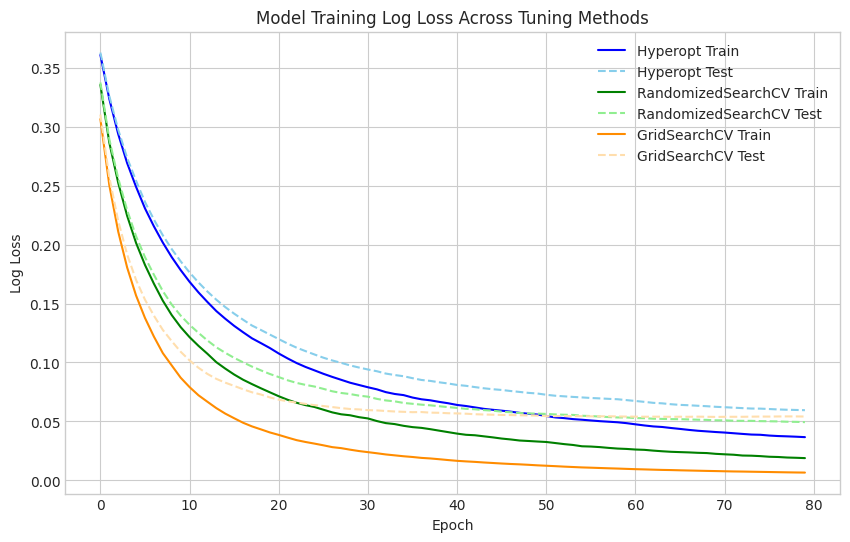

In [31]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def plot_log_loss(evals_result_hyperopt, evals_result_randomizedsearch, evals_result_gridsearch):
    # Find the minimum length of the log loss arrays
    min_len = min(len(evals_result_hyperopt['validation_0']['logloss']),
                  len(evals_result_randomizedsearch['validation_0']['logloss']),
                  len(evals_result_gridsearch['validation_0']['logloss']))
    
    # Adjust the x-axis to match the minimum length
    x_axis = range(0, min_len)
    
    # Define color schemes for clarity
    colors = {
        'hyperopt_train': 'blue',
        'hyperopt_test': 'skyblue',
        'randomized_train': 'green',
        'randomized_test': 'lightgreen',
        'gridsearch_train': 'darkorange',
        'gridsearch_test': 'navajowhite'
    }
    
    # Plot log loss, slicing each series to the minimum length
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis, evals_result_hyperopt['validation_0']['logloss'][:min_len], label='Hyperopt Train', color=colors['hyperopt_train'], linestyle='-')
    plt.plot(x_axis, evals_result_hyperopt['validation_1']['logloss'][:min_len], label='Hyperopt Test', color=colors['hyperopt_test'], linestyle='--')
    plt.plot(x_axis, evals_result_randomizedsearch['validation_0']['logloss'][:min_len], label='RandomizedSearchCV Train', color=colors['randomized_train'], linestyle='-')
    plt.plot(x_axis, evals_result_randomizedsearch['validation_1']['logloss'][:min_len], label='RandomizedSearchCV Test', color=colors['randomized_test'], linestyle='--')
    plt.plot(x_axis, evals_result_gridsearch['validation_0']['logloss'][:min_len], label='GridSearchCV Train', color=colors['gridsearch_train'], linestyle='-')
    plt.plot(x_axis, evals_result_gridsearch['validation_1']['logloss'][:min_len], label='GridSearchCV Test', color=colors['gridsearch_test'], linestyle='--')

    plt.legend()
    plt.ylabel('Log Loss')
    plt.xlabel('Epoch')
    plt.title('Model Training Log Loss Across Tuning Methods')
    plt.savefig('false_positives/images/xgboost_params_tuning.png', dpi=400, bbox_inches='tight')

    plt.show()

# Assuming you have evals_result_hyperopt, evals_result_randomizedsearch, evals_result_gridsearch from your training
plot_log_loss(evals_result_hyperopt, evals_result_randomizedsearch, evals_result_gridsearch)
